# Ready, Steady, Go AI (*Tutorial*)

This tutorial is a supplement to the paper, **Ready, Steady, Go AI: A Practical Tutorial on Fundamentals of Artificial Intelligence and Its Applications in Phenomics Image Analysis** (submitted to *Patterns, 2021*) by Farid Nakhle and Antoine Harfouche

Read the accompanying paper [here](https://doi.org).

# Table of contents


* **1. Background**
* **2. Downloading Segmented Images**
* **3. Balancing the Dataset**

# 1. Background


**Why do we need to balance a dataset?**

Data imbalance refers to an unequal distribution of classes within a dataset. In such scenario, a classification model could become biased, inaccurate, and might produce unsatisfactory results. Therefore, we balance the dataset either by oversampling the minority class or undersampling the majority classes. To demonstrate the two scenarios, both oversampling and undersampling will be applied. Here, we will oversample the training set using Augmentor.

**What is Augmentor?**

Augmentor uses geometric transformations to generate new images from a dataset in order to oversample it. This helps classification models learn patterns invariant to different geometric perturbations. Augmentor builds pipelines defined by a series of operations, such as rotating and flipping, to perform on a set of images. 

We will use it to oversample the leaf mold, Septoria leaf spot, target spot, early blight, mosaic virus, and spider mites classes of the training set, where each will reach 1500 images


# 2. Downloading Segmented Images


As a reminder, we are working with the PlantVillage dataset, originally obtained from [here](http://dx.doi.org/10.17632/tywbtsjrjv.1).
For this tutorial, we will be working with a subset of PlantVillage, where we will choose the tomato classes only. We have made the subset available [here](http://dx.doi.org/10.17632/4g7k9wptyd.1). 

The next code will automatically download the dataset segmented with SegNet.

**It is important to note that Colab deletes all unsaved data once the instance is recycled. Therefore, remember to download your results once you run the code.**

In [ ]:
import requests
import os
import zipfile

## FEEL FREE TO CHANGE THESE PARAMETERS
dataset_url = "http://faridnakhle.com/pv/tomato-split-cropped-segmented.zip"
save_data_to = "/content/dataset/tomato-segmented/"
dataset_file_name = "tomato-segmented.zip"
#######################################

if not os.path.exists(save_data_to):
    os.makedirs(save_data_to)

r = requests.get(dataset_url, stream = True, headers={"User-Agent": "Ready, Steady, Go AI"})

print("Downloading dataset...")  

with open(save_data_to + dataset_file_name, "wb") as file: 
    for block in r.iter_content(chunk_size = 1024):
         if block: 
             file.write(block)

## Extract downloaded zip dataset file
print("Dataset downloaded")  
print("Extracting files...")  
with zipfile.ZipFile(save_data_to + dataset_file_name, 'r') as zip_dataset:
    zip_dataset.extractall(save_data_to)

## Delete the zip file as we no longer need it
os.remove(save_data_to + dataset_file_name)
print("All done!")  


Dataset downloaded
Extracting files...
All done!


# 3. Balancing the Dataset

Before oversampling the dataset, we can take a look at the current data distribution

[Text(0, 0, 'Tomato___Tomato_mosaic_virus'),
 Text(0, 0, 'Tomato___Bacterial_spot'),
 Text(0, 0, 'Tomato___Septoria_leaf_spot'),
 Text(0, 0, 'Tomato___Early_blight'),
 Text(0, 0, 'Tomato___Target_Spot'),
 Text(0, 0, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'),
 Text(0, 0, 'Tomato___Spider_mites Two-spotted_spider_mite'),
 Text(0, 0, 'Tomato___healthy'),
 Text(0, 0, 'Tomato___Leaf_Mold'),
 Text(0, 0, 'Tomato___Late_blight')]

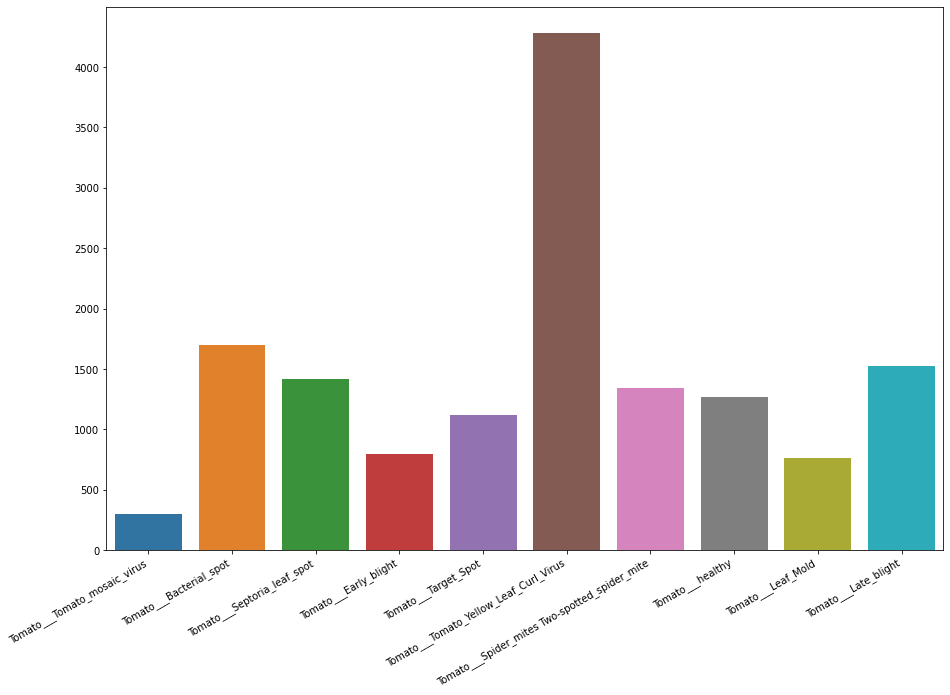

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

train_dir = '/content/dataset/tomato-segmented/train/'
train_classes = [path for path in os.listdir(train_dir)]
train_imgs = dict([(ID, os.listdir(os.path.join(train_dir, ID))) for ID in train_classes])
train_classes_count = []
for trainClass in train_classes:
  train_classes_count.append(len(train_imgs[trainClass]))

plt.figure(figsize=(15, 10))
g = sns.barplot(x=train_classes, y=train_classes_count)
g.set_xticklabels(labels=train_classes, rotation=30, ha='right')

We will use Augmentor to oversample the leaf mold, Septoria leaf spot, target spot, early blight, mosaic virus, and spider mites classes of the training set, for each to reach 1500 images. The healthy class will be oversampled using a deep convolutional generative adversarial network and the yellow leaf curl virus will be downsampled using K-nearest neighbor in other Colab notebooks.

In [ ]:
!pip install Augmentor
import Augmentor
import os

def makedir(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)

datasets_root_dir = '/content/dataset/tomato-segmented/'
dir = datasets_root_dir + 'train/'
target_dir = dir #same directory as input
makedir(target_dir)

folders = [os.path.join(dir, folder) for folder in next(os.walk(dir))[1]]
target_folders = [os.path.join(target_dir, folder) for folder in next(os.walk(dir))[1]]

requiredNbrOfImages = 1500

for i in range(len(folders)):
    if folders[i].endswith("healthy") == False: #skip healthy because we are using DCGAN to augment it
        path, dirs, files = next(os.walk(folders[i]))
        nbrOfImages = len(files)
        nbrOfImagesNeeded = requiredNbrOfImages - nbrOfImages
          
        if nbrOfImagesNeeded > 0:
            tfd = target_folders[i]
            print ("saving in " + tfd)
            p = Augmentor.Pipeline(source_directory=folders[i], output_directory=tfd)
            p.rotate(probability=1, max_left_rotation=15, max_right_rotation=15)
            p.flip_left_right(probability=0.5)
            p.skew(probability=1, magnitude=0.2)
            p.flip_left_right(probability=0.5)
            p.shear(probability=1, max_shear_left=10, max_shear_right=10)
            p.flip_left_right(probability=0.5)
            p.sample(nbrOfImagesNeeded)

Executing Pipeline:   0%|          | 0/1202 [00:00<?, ? Samples/s]

saving in /content/dataset/tomato-segmented/train/Tomato___Tomato_mosaic_virus
Initialised with 298 image(s) found.
Output directory set to /content/dataset/tomato-segmented/train/Tomato___Tomato_mosaic_virus.

Processing <PIL.Image.Image image mode=RGB size=118x198 at 0x7F1A5EADD2D0>: 100%|██████████| 1202/1202 [00:20<00:00, 60.01 Samples/s]


saving in /content/dataset/tomato-segmented/train/Tomato___Septoria_leaf_spot


Processing <PIL.Image.Image image mode=RGB size=188x196 at 0x7F1A635435D0>:   1%|          | 1/84 [00:00<00:11,  7.17 Samples/s]

Initialised with 1416 image(s) found.
Output directory set to /content/dataset/tomato-segmented/train/Tomato___Septoria_leaf_spot.

Processing <PIL.Image.Image image mode=RGB size=223x238 at 0x7F1A63836F10>: 100%|██████████| 84/84 [00:01<00:00, 45.64 Samples/s]
Executing Pipeline:   0%|          | 0/700 [00:00<?, ? Samples/s]

saving in /content/dataset/tomato-segmented/train/Tomato___Early_blight
Initialised with 800 image(s) found.
Output directory set to /content/dataset/tomato-segmented/train/Tomato___Early_blight.

Processing <PIL.Image.Image image mode=RGB size=128x215 at 0x7F1A5EBAC190>: 100%|██████████| 700/700 [00:15<00:00, 44.29 Samples/s]
Executing Pipeline:   0%|          | 0/377 [00:00<?, ? Samples/s]

saving in /content/dataset/tomato-segmented/train/Tomato___Target_Spot
Initialised with 1123 image(s) found.
Output directory set to /content/dataset/tomato-segmented/train/Tomato___Target_Spot.

Processing <PIL.Image.Image image mode=RGB size=195x235 at 0x7F1A5EBC1490>:  27%|██▋       | 102/377 [00:02<00:05, 50.40 Samples/s]

Now that the classes are augmented, let's take another look at the distribution

[Text(0, 0, 'Tomato___Tomato_mosaic_virus'),
 Text(0, 0, 'Tomato___Bacterial_spot'),
 Text(0, 0, 'Tomato___Septoria_leaf_spot'),
 Text(0, 0, 'Tomato___Early_blight'),
 Text(0, 0, 'Tomato___Target_Spot'),
 Text(0, 0, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'),
 Text(0, 0, 'Tomato___Spider_mites Two-spotted_spider_mite'),
 Text(0, 0, 'Tomato___healthy'),
 Text(0, 0, 'Tomato___Leaf_Mold'),
 Text(0, 0, 'Tomato___Late_blight')]

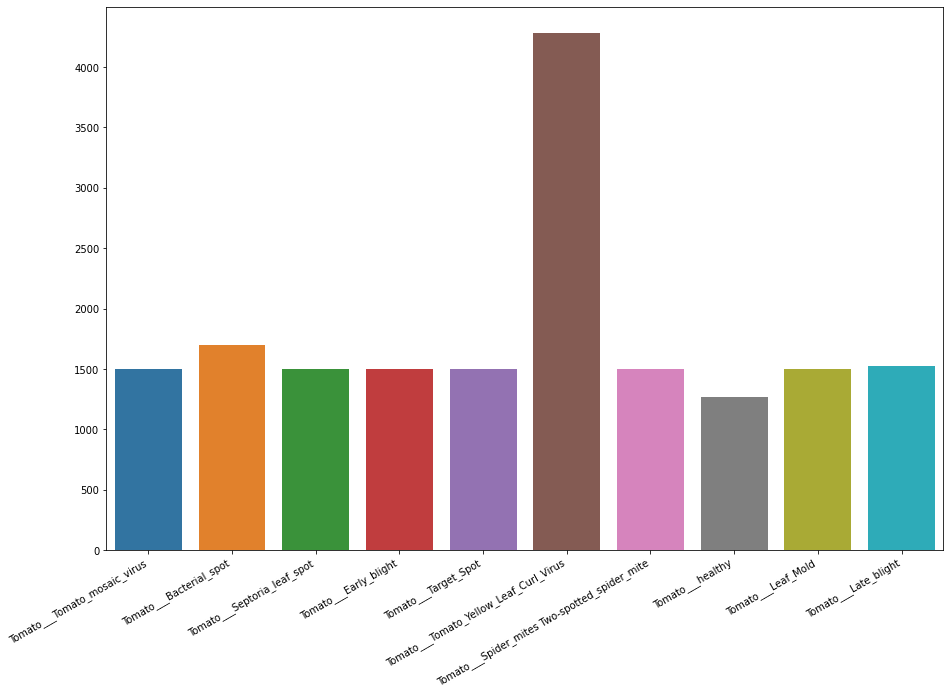

In [ ]:
train_classes = [path for path in os.listdir(train_dir)]
train_imgs = dict([(ID, os.listdir(os.path.join(train_dir, ID))) for ID in train_classes])
train_classes_count = []
for trainClass in train_classes:
  train_classes_count.append(len(train_imgs[trainClass]))

plt.figure(figsize=(15, 10))
g = sns.barplot(x=train_classes, y=train_classes_count)
g.set_xticklabels(labels=train_classes, rotation=30, ha='right')

All classes are now balanced except for the yellow leaf curl which will be downsampled.